# Library Load

In [ ]:
from google.colab import userdata
username = userdata.get('KAGGLE_USER')
key = userdata.get('KAGGLE_KEY')
# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c forest-type-classification-spai
!unzip forest-type-classification-spai

  0% 0.00/463k [00:00<?, ?B/s]
100% 463k/463k [00:00<00:00, 80.6MB/s]
Archive:  forest-type-classification-spai.zip
  inflating: metaData.csv            
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip install pandas-summary -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 2.4 MB/s eta 0:00:00


In [ ]:
pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from pandas_summary import DataFrameSummary

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay  # newly learnt this time!

from sklearn.metrics import classification_report, recall_score, confusion_matrix,ConfusionMatrixDisplay, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import optuna
from optuna.samplers import TPESampler
from tqdm import tqdm


plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
sns.set(font_scale = 1)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("Let's start!")

Let's start!


In [ ]:
df = pd.read_csv('/content/train.csv')
df = df.drop('id',axis=1)
display(df.shape, df.head())

(13053, 13)

,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9,nforest_type
0,293,1927,1038,278,475,453,987,1773,2184,1900,2343,3039,MDF
1,197,1598,697,201,347,228,682,1982,2449,2254,2685,2690,DDF
2,929,1975,1031,982,1020,856,1220,2051,2421,2392,2671,2683,MDF
3,132,1560,689,189,408,175,609,2117,2907,3024,3005,2955,MDF
4,241,1944,1131,362,538,487,918,1549,1844,1702,2077,2043,MDF


In [ ]:
df['nforest_type'].unique()

array(['MDF', 'DDF', 'DEF'], dtype=object)

In [ ]:
# When summarize the data you can use DataFrameSummary()

# df_info = DataFrameSummary(df)
# df_info.summary().T

In [ ]:
# Or customize according to what you'd like to know.

df_info2 = pd.DataFrame(columns=['Name of Col', 'Num of Null', 'Dtype', 'N_unique'])

for i in range(0, len(df.columns)):
    df_info2.loc[i] = [df.columns[i],
                      df[df.columns[i]].isnull().sum(),
                      df[df.columns[i]].dtypes,
                      df[df.columns[i]].nunique()]

df_info2

,Name of Col,Num of Null,Dtype,N_unique
0,b1,0,int64,1375
1,b11,0,int64,1628
2,b12,0,int64,1306
3,b2,0,int64,1242
4,b3,0,int64,1219
5,b4,0,int64,1215
6,b5,0,int64,1453
7,b6,0,int64,1815
8,b7,0,int64,2180
9,b8,0,int64,2287


# EDA

## Distribution of target feature

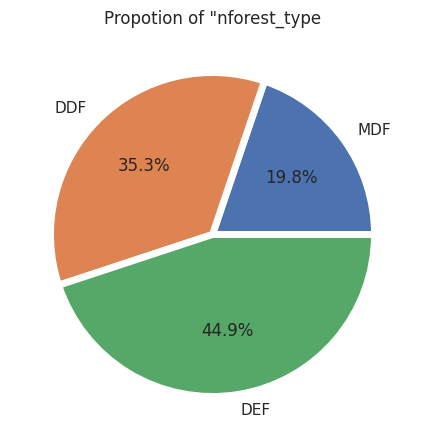

In [ ]:
x = df['nforest_type'].value_counts().sort_values()

plt.figure(figsize=(5, 5))
ax = plt.pie(x = x, labels=['MDF', 'DDF', 'DEF'], autopct = '%1.1f%%', wedgeprops = {'linewidth': 5})
plt.title('Propotion of "nforest_type')
plt.style.use(['fivethirtyeight'])
plt.show()

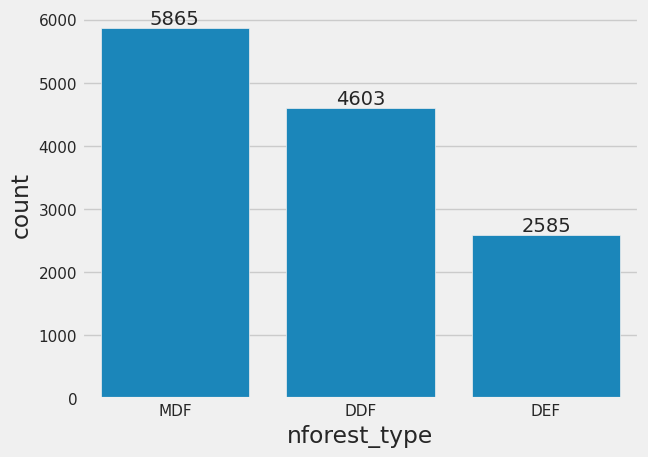

In [ ]:
ax = sns.countplot(data = df, x = 'nforest_type')

ax.bar_label(ax.containers[0])
# ax.set_ylim(0, 10000)

plt.show()

<br>

## Numerical features

In [ ]:
# dtype = pd.DataFrame(df.summary().loc['types'] == 'numeric')
num_cols = df.select_dtypes(include='number').columns
list(num_cols)

['b1', 'b11', 'b12', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b8_a', 'b9']

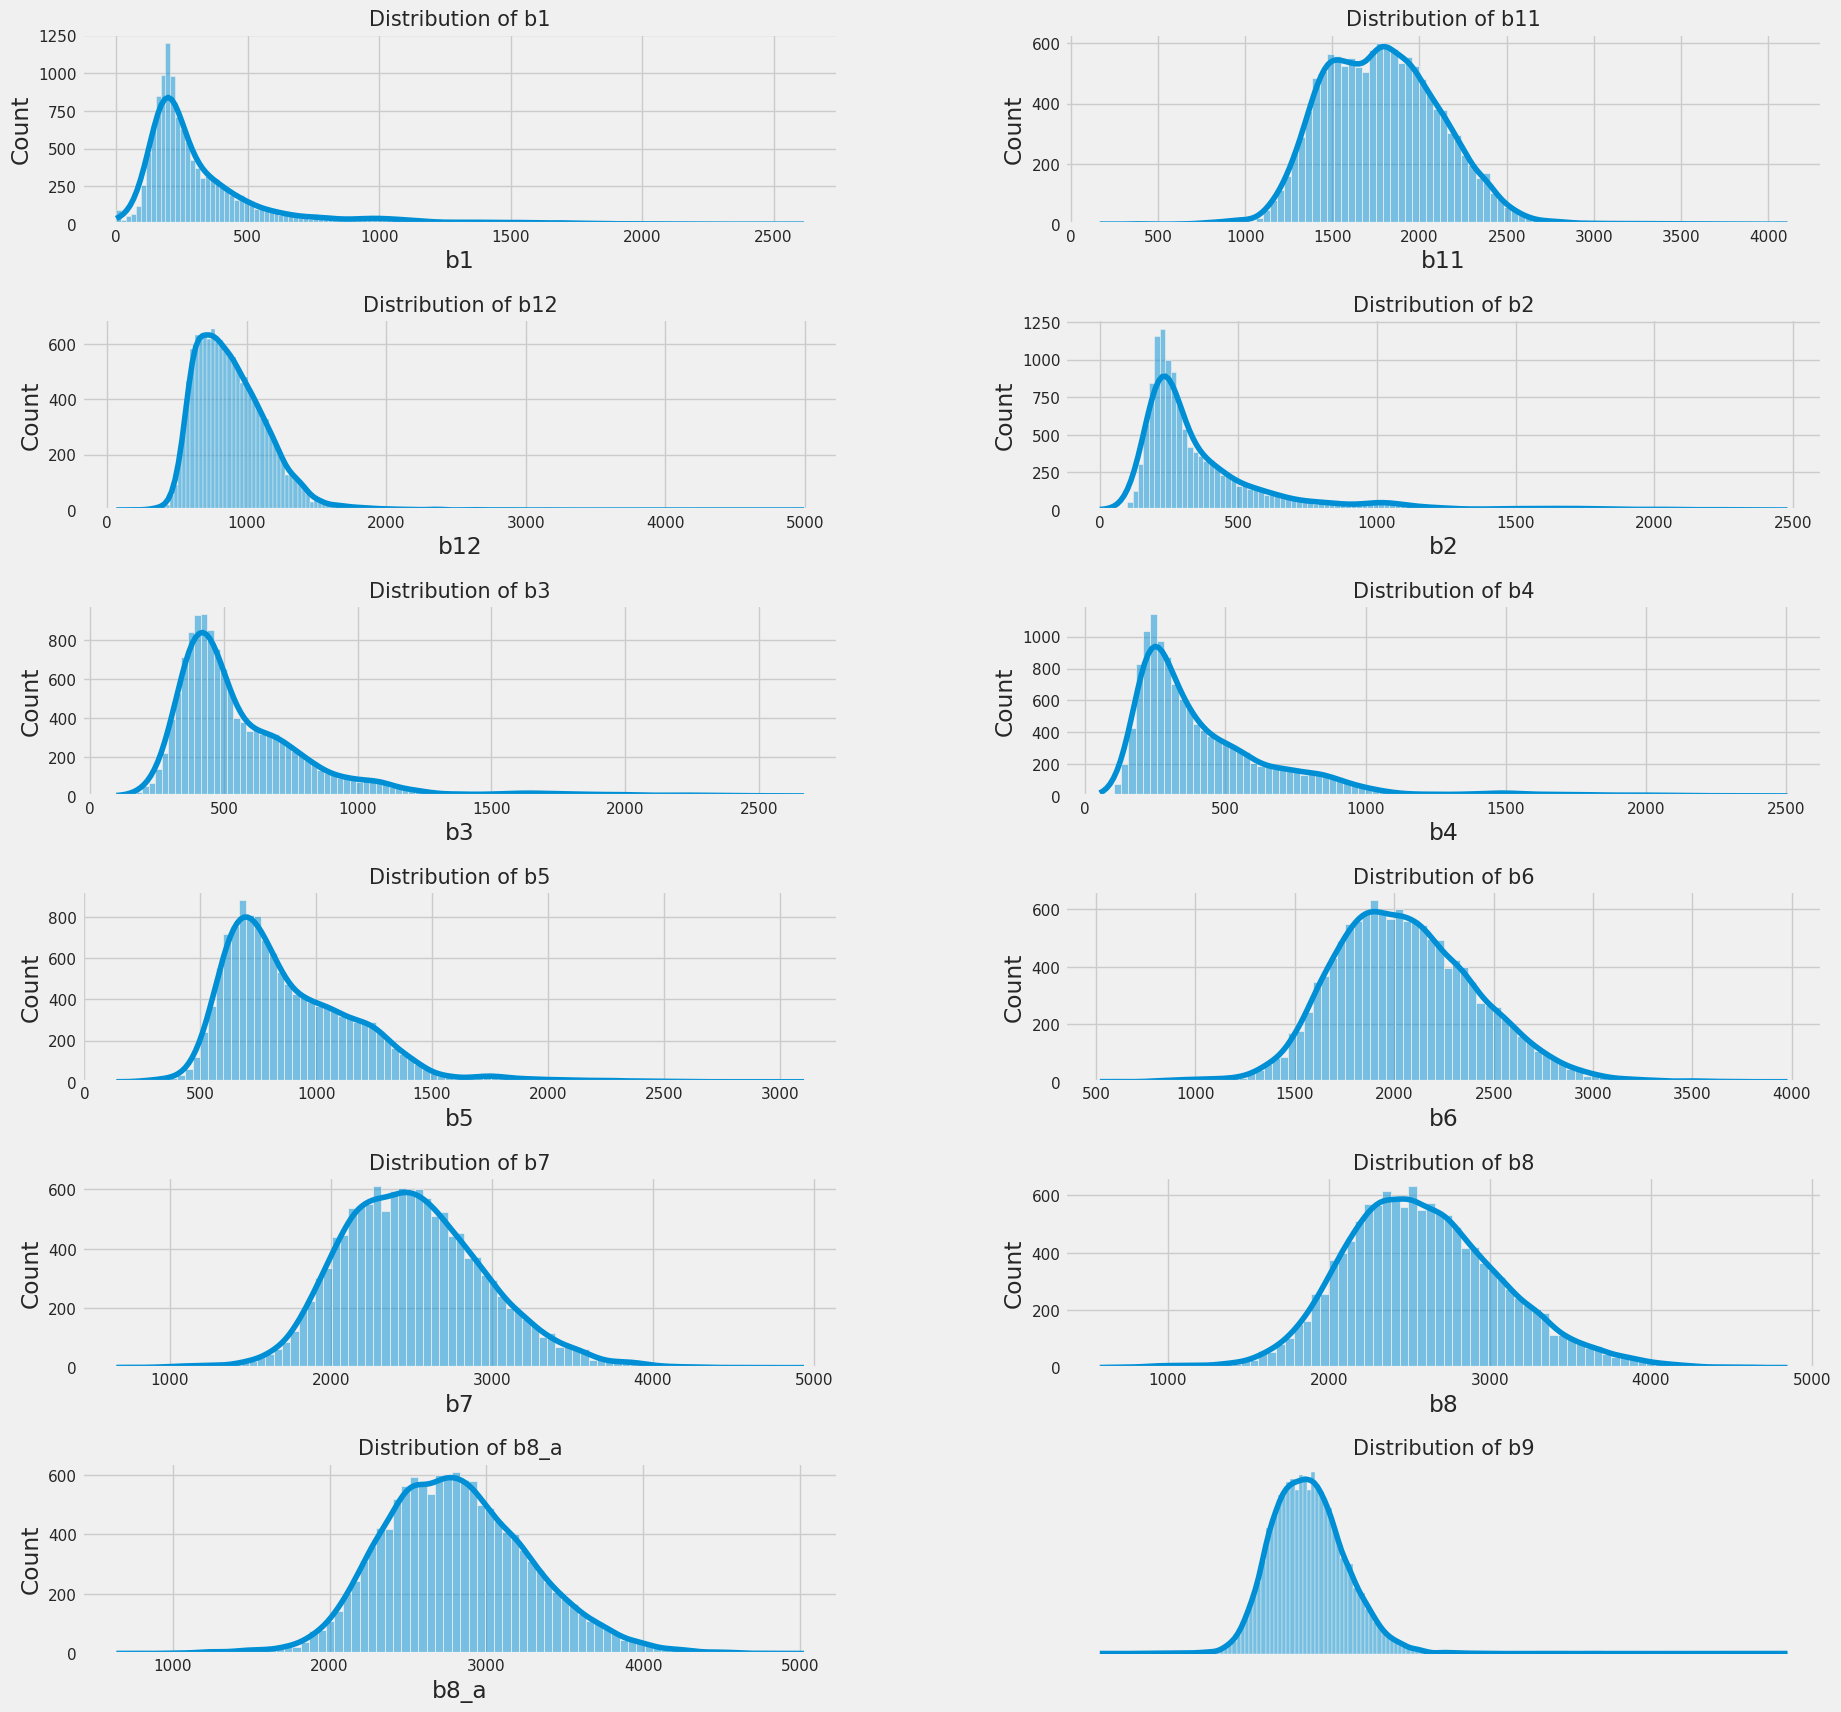

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize = (20, 20))
axes = axes.flatten()

for col, ax in zip(num_cols, axes):
    ax = sns.histplot(data = df, x = col, ax = ax, kde = True)
    ax.set_title(f"Distribution of {col}", fontsize=15)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

axes[-1].axis('off')
plt.show()

# Preprocessing

In [ ]:
# df['id'] = df['FastingBS'].astype('O')

In [ ]:
ss = StandardScaler()

df[num_cols] = ss.fit_transform(df[num_cols])

In [ ]:
df_dm = pd.get_dummies(df)  # drop_first option

display(df_dm.shape, df_dm.head(3))

(13053, 15)

,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9,nforest_type_DDF,nforest_type_DEF,nforest_type_MDF
0,-0.197169,0.420392,0.534636,-0.392876,-0.357525,0.035673,0.299676,-0.780570,-0.724201,-1.377012,-0.966083,0.532853,False,False,True
1,-0.513762,-0.558605,-0.736235,-0.640432,-0.798139,-0.730470,-0.710492,-0.205260,-0.139301,-0.665410,-0.248431,-0.283408,True,False,False
2,1.900254,0.563225,0.508548,1.870492,1.518524,1.407921,1.071378,-0.015325,-0.201102,-0.388006,-0.277809,-0.299780,False,False,True


Numeric features are scaled and others are successfully encoded by one-hot encoding.

## Correlation analysis

In [ ]:
corr = df_dm.corr().round(2)

In [ ]:
df_dm

,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9,nforest_type_DDF,nforest_type_DEF,nforest_type_MDF
0,-0.197169,0.420392,0.534636,-0.392876,-0.357525,0.035673,0.299676,-0.780570,-0.724201,-1.377012,-0.966083,0.532853,False,False,True
1,-0.513762,-0.558605,-0.736235,-0.640432,-0.798139,-0.730470,-0.710492,-0.205260,-0.139301,-0.665410,-0.248431,-0.283408,True,False,False
2,1.900254,0.563225,0.508548,1.870492,1.518524,1.407921,1.071378,-0.015325,-0.201102,-0.388006,-0.277809,-0.299780,False,False,True
3,-0.728121,-0.671681,-0.766050,-0.679012,-0.588159,-0.910939,-0.952270,0.166352,0.871582,0.882423,0.423056,0.336389,False,False,True
4,-0.368657,0.470979,0.881237,-0.122815,-0.140661,0.151446,0.071146,-1.397170,-1.474638,-1.775026,-1.524257,-1.796648,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13048,0.069955,0.459076,0.594266,-0.058515,-0.047719,0.188902,0.266556,-1.042075,-1.287028,-0.956885,-1.075200,-1.663333,True,False,False
13049,5.376173,5.404650,6.803272,3.928099,4.141551,4.506545,4.694734,3.940277,3.063300,2.691579,2.714505,7.582167,True,False,False
13050,1.936530,0.658446,0.944594,1.847987,1.725062,1.789290,1.177363,-0.761301,-1.167841,-1.292584,-1.167529,-1.499613,True,False,False
13051,2.708224,1.566028,1.101124,2.288443,1.883407,1.520289,1.369460,1.250908,1.264458,0.934688,1.243529,1.330403,False,False,True


In [ ]:
corr

,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9,nforest_type_DDF,nforest_type_DEF,nforest_type_MDF
b1,1.00,0.44,0.52,0.97,0.93,0.89,0.81,0.26,0.10,0.05,0.07,0.05,0.00,-0.04,0.03
b11,0.44,1.00,0.92,0.49,0.59,0.62,0.74,0.45,0.32,0.30,0.35,0.20,-0.06,-0.31,0.30
b12,0.52,0.92,1.00,0.56,0.65,0.72,0.78,0.25,0.10,0.09,0.11,0.03,-0.02,-0.28,0.24
b2,0.97,0.49,0.56,1.00,0.97,0.94,0.86,0.23,0.07,0.05,0.04,-0.01,-0.01,-0.05,0.04
b3,0.93,0.59,0.65,0.97,1.00,0.96,0.93,0.34,0.15,0.15,0.13,0.04,-0.00,-0.09,0.08
b4,0.89,0.62,0.72,0.94,0.96,1.00,0.93,0.18,-0.02,-0.01,-0.02,-0.10,0.01,-0.11,0.08
b5,0.81,0.74,0.78,0.86,0.93,0.93,1.00,0.40,0.20,0.17,0.20,0.06,0.02,-0.16,0.11
b6,0.26,0.45,0.25,0.23,0.34,0.18,0.40,1.00,0.95,0.85,0.95,0.77,-0.17,0.06,0.11
b7,0.10,0.32,0.10,0.07,0.15,-0.02,0.20,0.95,1.00,0.88,0.98,0.83,-0.21,0.11,0.11
b8,0.05,0.30,0.09,0.05,0.15,-0.01,0.17,0.85,0.88,1.00,0.88,0.71,-0.18,0.05,0.13


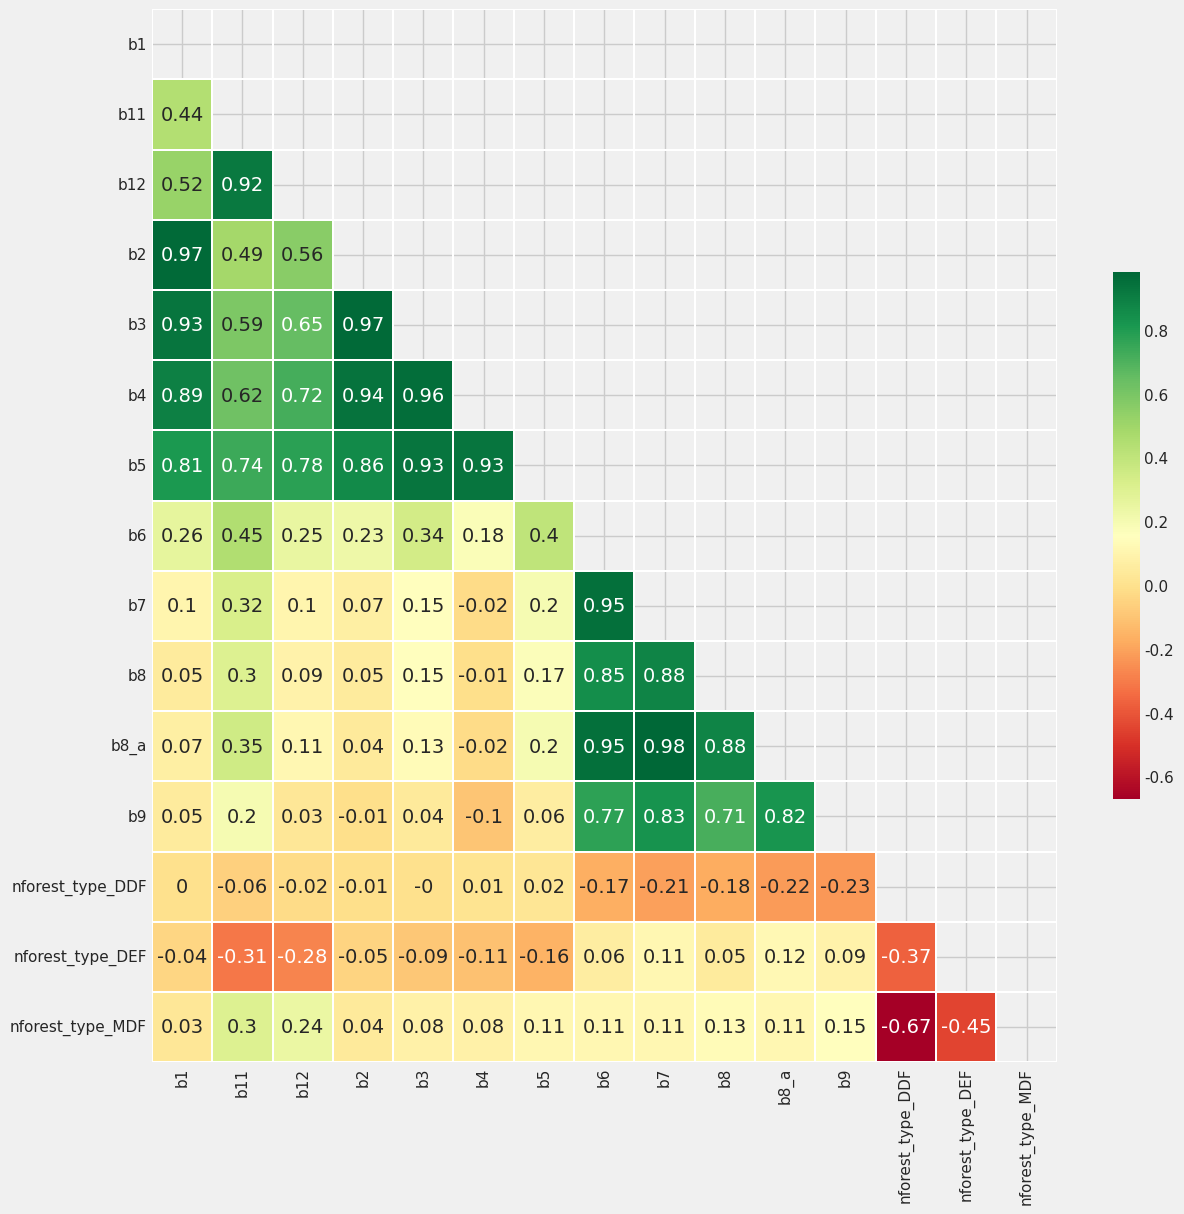

In [ ]:
plt.figure(figsize = (13, 13))

mask = np.zeros_like(corr, dtype = bool)
mask[np.triu_indices_from(mask)] = True

heat_map = sns.heatmap(corr,
                       annot = True,
                       cmap = 'RdYlGn',
                       mask = mask,
                       linewidths = 0.01,
                       cbar_kws = {'shrink' : .5})

In [ ]:
# First of all, we need to split the data as train and test dataset.
# We will use train dataset for training and validation.

X = df.drop(['nforest_type'], axis=1)
y = df['nforest_type']

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size = 0.3, stratify = y, random_state=42)

display(X_trn.shape, y_trn.shape, X_tst.shape, y_tst.shape)

(9137, 12)

(9137,)

(3916, 12)

(3916,)

In [ ]:
X_trn.reset_index(drop=True, inplace=True)
y_trn.reset_index(drop=True, inplace=True)
X_tst.reset_index(drop=True, inplace=True)
y_tst.reset_index(drop=True, inplace=True)

## LGBClassifier

In [ ]:
from sklearn.metrics import accuracy_score
SEED = 42
n_splits = 5
skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=SEED)

preds_lgb = []
mean_recall = 0

model_lgb = LGBMClassifier(objective='multiclass', random_state=SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]

    model_lgb.fit(X_train, y_train,
                  eval_set = [(X_train, y_train), (X_val, y_val)],
                  eval_metric = 'multi_logloss')

    y_preds = model_lgb.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_recall += score

    print(f"Fold {fold}'s score: {score:.4f}")

    preds_lgb.append(model_lgb.predict(X_tst))

print("========================================")
print(f"Mean recall of all folds: {mean_recall / n_splits:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 7309, number of used features: 12
[LightGBM] [Info] Start training from score -1.042481
[LightGBM] [Info] Start training from score -1.618923
[LightGBM] [Info] Start training from score -0.800044
Fold 0's score: 0.6608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 7309, number of used features: 12
[LightGBM] [Info] Start training from score -1.042481
[LightGBM] [Info] Start training from score -1.618923
[LightGBM] [Info] Start training from score -0.800044
Fold 1's score: 0.6827
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

In [ ]:
model_lgb

LGBMClassifier(objective='multiclass', random_state=42)

In [ ]:
y_tst

0       MDF
1       DEF
2       DEF
3       DDF
4       DDF
       ... 
3911    DEF
3912    MDF
3913    MDF
3914    MDF
3915    MDF
Name: nforest_type, Length: 3916, dtype: object

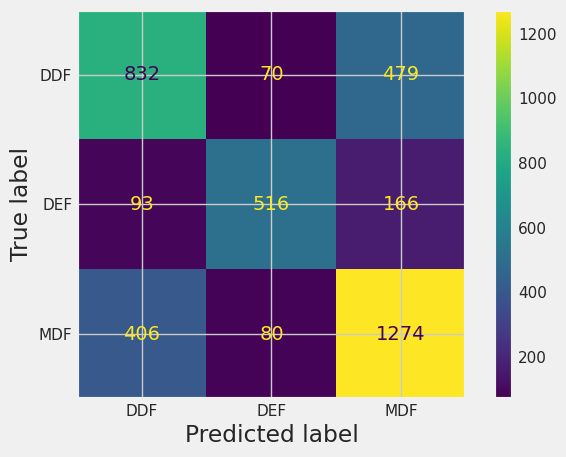

In [ ]:
cm = confusion_matrix(y_tst, model_lgb.predict(X_tst), labels=model_lgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_lgb.classes_)
disp.plot()
# <...>
plt.show()
# cm = ConfusionMatrixDisplay(model_lgb,
#                            X_tst, y_tst,
#                            display_labels=[0, 1,2])

# cm.ax_.set_title('Confusion Matrix_lgb')
# plt.grid()

## XGBClassifier

In [ ]:
y_trn

0       DEF
1       MDF
2       DEF
3       MDF
4       DDF
       ... 
9132    MDF
9133    MDF
9134    MDF
9135    MDF
9136    DDF
Name: nforest_type, Length: 9137, dtype: object

In [ ]:
class_names = {"DDF":0, "DEF":1, "MDF":2}  # Manual mapping (older versions)
y_trn = y_trn.map(class_names)
y_trn

0       1
1       2
2       1
3       2
4       0
       ..
9132    2
9133    2
9134    2
9135    2
9136    0
Name: nforest_type, Length: 9137, dtype: int64

In [ ]:
y_tst = y_tst.map(class_names)
y_tst

0       2
1       1
2       1
3       0
4       0
       ..
3911    1
3912    2
3913    2
3914    2
3915    2
Name: nforest_type, Length: 3916, dtype: int64

In [ ]:
SEED = 42
n_splits = 5
skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=SEED)

preds_xgb = []
mean_recall = 0

model_xgb = XGBClassifier(objective='micro:logistic', random_state=SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]

    model_xgb.fit(X_train, y_train,
                  verbose = False,
                  eval_set = [(X_train, y_train), (X_val, y_val)],
                  eval_metric = 'mlogloss',
                  early_stopping_rounds = 100)

    y_preds = model_xgb.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_recall += score

    print(f"Fold {fold}'s score: {score:.4f}")

    preds_xgb.append(model_xgb.predict(X_tst))

print("========================================")
print(f"Mean recall of all folds: {mean_recall / n_splits:.4f}")

Fold 0's score: 0.6647
Fold 1's score: 0.6729
Fold 2's score: 0.6700
Fold 3's score: 0.6700
Fold 4's score: 0.6804
Mean recall of all folds: 0.6716


In [ ]:
y_tst

0       2
1       1
2       1
3       0
4       0
       ..
3911    1
3912    2
3913    2
3914    2
3915    2
Name: nforest_type, Length: 3916, dtype: int64

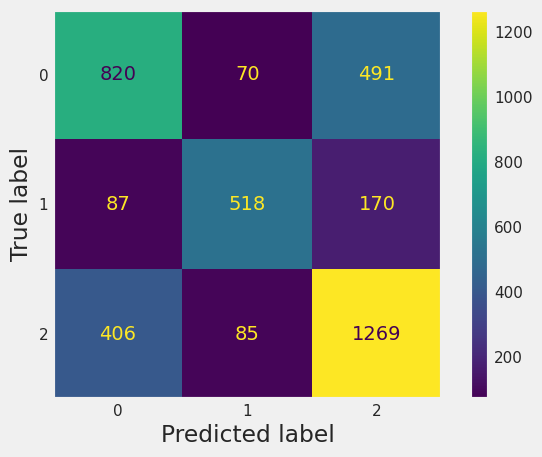

In [ ]:
cm = confusion_matrix(y_tst, model_xgb.predict(X_tst), labels=model_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_xgb.classes_)
disp.plot()
# cm.ax_.set_title('Confusion Matrix_xgb')
plt.grid()
plt.show()
# cm = plot_confusion_matrix(model_xgb,
#                            X_tst, y_tst,
#                            display_labels=[0, 1,2],
#                            cmap='Blues')

# cm.ax_.set_title('Confusion Matrix_xgb')
# plt.grid()

## Random Forest Classifier

In [ ]:
SEED = 42
n_splits = 5
skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=SEED)

preds_rf = []
mean_recall = 0

model_rf = RandomForestClassifier(random_state=SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]

    model_rf.fit(X_train, y_train)

    y_preds = model_rf.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_recall += score

    print(f"Fold {fold}'s score: {score:.4f}")

    preds_rf.append(model_rf.predict(X_tst))

print("========================================")
print(f"Mean recall of all folds: {mean_recall / n_splits:.4f}")

Fold 0's score: 0.6592
Fold 1's score: 0.6723
Fold 2's score: 0.6650
Fold 3's score: 0.6634
Fold 4's score: 0.6721
Mean recall of all folds: 0.6664


In [ ]:
y_tst

0       2
1       1
2       1
3       0
4       0
       ..
3911    1
3912    2
3913    2
3914    2
3915    2
Name: nforest_type, Length: 3916, dtype: int64

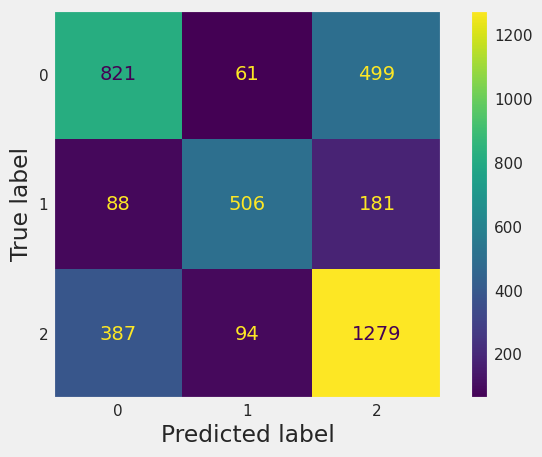

In [ ]:
cm = confusion_matrix(y_tst, model_rf.predict(X_tst), labels=model_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_rf.classes_)
disp.plot()
# cm.ax_.set_title('Confusion Matrix_xgb')
plt.grid()
plt.show()
# cm = plot_confusion_matrix(model_rf,
#                            X_tst, y_tst,
#                            display_labels=[0, 1,2],
#                            cmap='Blues')

# cm.ax_.set_title('Confusion Matrix_xgb')
# plt.grid()

## Extra Trees Classifier

In [ ]:
SEED = 42
n_splits = 5
skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=SEED)

preds_et = []
mean_recall = 0

model_et = ExtraTreesClassifier(random_state=SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]

    model_et.fit(X_train, y_train)

    y_preds = model_et.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_recall += score

    print(f"Fold {fold}'s score: {score:.4f}")

    preds_et.append(model_et.predict(X_tst))

print("========================================")
print(f"Mean recall of all folds: {mean_recall / n_splits:.4f}")

Fold 0's score: 0.6652
Fold 1's score: 0.6729
Fold 2's score: 0.6689
Fold 3's score: 0.6645
Fold 4's score: 0.6831
Mean recall of all folds: 0.6709


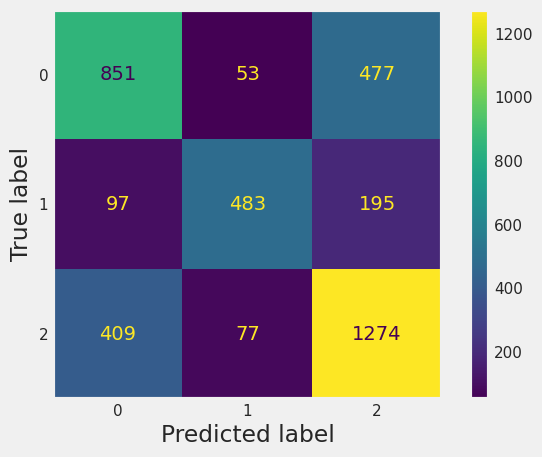

In [ ]:
cm = confusion_matrix(y_tst, model_et.predict(X_tst), labels=model_et.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_et.classes_)
disp.plot()
# cm.ax_.set_title('Confusion Matrix_xgb')
plt.grid()
plt.show()

<br>

## Voting Classifier

In [ ]:
SEED = 42
n_splits = 5
skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=SEED)

preds_vote = []
mean_recall = 0

model_vote = VotingClassifier(estimators = [('lgb', model_lgb),
                                            ('xgb', model_xgb),
                                            ('rf', model_rf),
                                            ('et', model_et)], voting = 'soft')

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]

    model_vote.fit(X_train, y_train)

    y_preds = model_vote.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_recall += score

    print(f"Fold {fold}'s score: {score:.4f}")

    preds_vote.append(model_vote.predict(X_tst))

print("========================================")
print(f"Mean recall of all folds: {mean_recall / n_splits:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 7309, number of used features: 12
[LightGBM] [Info] Start training from score -1.042481
[LightGBM] [Info] Start training from score -1.618923
[LightGBM] [Info] Start training from score -0.800044
Fold 0's score: 0.6690
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 7309, number of used features: 12
[LightGBM] [Info] Start training from score -1.042481
[LightGBM] [Info] Start training from score -1.618923
[LightGBM] [Info] Start training from score -0.800044
Fold 1's score: 0.6893
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

In [ ]:
test_data = pd.read_csv('/content/test.csv')
test_data = test_data.drop('id',axis=1)
submit = pd.read_csv('/content/sample_submission.csv')

In [ ]:
test_data[num_cols] = ss.fit_transform(test_data[num_cols])
test_data

,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9
0,-0.916948,-0.978027,-0.692203,-0.259865,-0.143734,-0.191142,-0.102750,-0.587548,-0.298031,-0.365202,-0.353808,-0.454514
1,-0.339525,-0.714397,-0.699850,-0.159052,-0.150678,-0.370996,-0.533986,-0.837367,-0.687778,-0.176172,-0.876429,-0.485171
2,-0.419630,1.773804,0.932830,-0.324906,0.106264,-0.073545,0.291714,1.512578,1.606913,1.631680,1.790598,0.851945
3,0.020947,0.763713,0.994008,-0.279377,0.022931,0.151272,0.348543,-0.771481,-1.219848,-0.572331,-1.019528,-1.044071
4,-0.529774,-0.903974,-0.619554,-0.321654,-0.435397,-0.163472,-0.684418,-1.504466,-1.154160,-0.697010,-1.206178,-1.402522
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.344704,-0.204908,-0.241017,0.107615,0.331956,0.033675,0.268313,1.089808,0.873400,0.817242,0.714247,1.236336
3996,-0.306148,2.780933,2.404919,0.253956,0.738201,1.112797,1.391533,0.820772,0.358846,0.240096,0.892602,0.160984
3997,-0.369565,-0.797337,-0.978973,-0.464743,-0.543035,-0.592354,-0.597502,0.419963,0.742025,0.945943,0.631292,0.705735
3998,-0.409617,0.251262,-0.382491,-0.477752,-0.431925,-0.692657,-0.584130,1.251778,2.103950,1.456727,2.033244,0.880244


In [ ]:
result = model_vote.predict(test_data)
result_names = {0: "DDF", 1: "DEF", 2: "MDF"}  # Manual mapping (older versions)

# Map integer predictions to class names
predicted_classes = [result_names[i] for i in result.reshape(-1)]
submit['nforest_type'] = predicted_classes
submit.to_csv('VotingClassifier.csv',index=False)

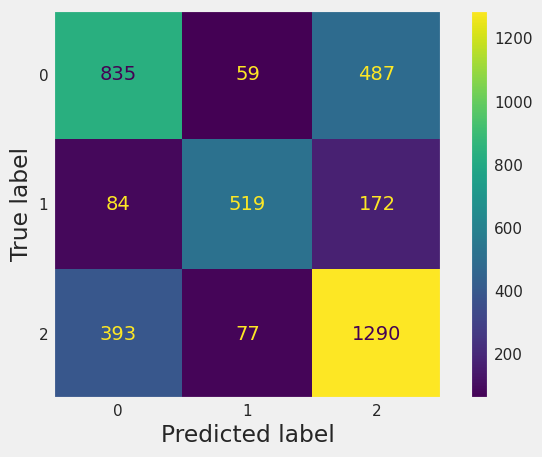

In [ ]:
cm = confusion_matrix(y_tst, model_vote.predict(X_tst), labels=model_vote.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_vote.classes_)
disp.plot()
# cm.ax_.set_title('Confusion Matrix_xgb')
plt.grid()
plt.show()

## Stacking Classifier

In [ ]:
# Definition of meta model.

model_lr = LogisticRegression(random_state=SEED)

In [ ]:
SEED = 42
n_splits = 5
skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=SEED)

preds_stack = []
mean_recall = 0

model_stack = StackingClassifier(estimators = [('lgb', model_lgb),
                                            ('xgb', model_xgb),
                                            ('rf', model_rf),
                                            ('et', model_et)], final_estimator= model_lr)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]

    model_stack.fit(X_train, y_train)

    y_preds = model_stack.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_recall += score

    print(f"Fold {fold}'s score: {score:.4f}")

    preds_stack.append(model_stack.predict(X_tst))

print("========================================")
print(f"Mean recall of all folds: {mean_recall / n_splits:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 7309, number of used features: 12
[LightGBM] [Info] Start training from score -1.042481
[LightGBM] [Info] Start training from score -1.618923
[LightGBM] [Info] Start training from score -0.800044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5847, number of used features: 12
[LightGBM] [Info] Start training from score -1.042252
[LightGBM] [Info] Start training from score -1.619234
[LightGBM] [Info] Start training from score -0.800086
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 secon

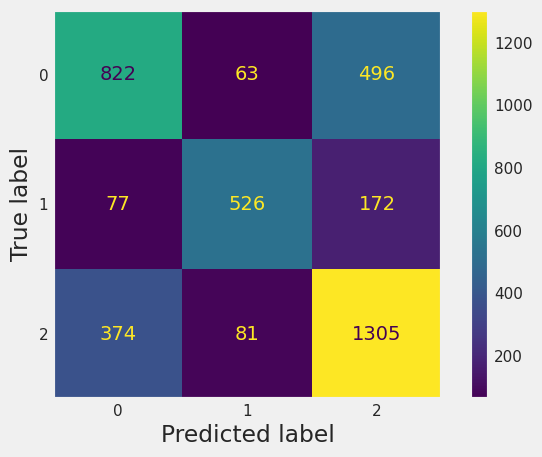

In [ ]:
cm = confusion_matrix(y_tst, model_stack.predict(X_tst), labels=model_stack.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_stack.classes_)
disp.plot()
# cm.ax_.set_title('Confusion Matrix_xgb')
plt.grid()
plt.show()

In [ ]:
result = model_stack.predict(test_data)
result_names = {0: "DDF", 1: "DEF", 2: "MDF"}  # Manual mapping (older versions)

# Map integer predictions to class names
predicted_classes = [result_names[i] for i in result.reshape(-1)]
submit['nforest_type'] = predicted_classes
submit.to_csv('StackingClassifier.csv',index=False)